In [30]:
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline
import numba
from numba import cuda
from IPython.html import widgets

In [31]:
N = 1536,1024
NSNAPSHOT = 200
LX, LY = 18.0, 12.0
dx, dy = LX/N[0], LY/N[1]
v = 1.0
dt = 0.5 * dx / v

In [32]:
# Storage for plotting the wave
ustore = np.empty((NSNAPSHOT + 1, N[0], N[1]))
tstore = np.empty(NSNAPSHOT + 1)

In [33]:
# GPU device arrays for wave calculation
dev_u1 = cuda.device_array(N)
dev_u2 = cuda.device_array_like(dev_u1)

In [34]:
# Arrays for setting the initial conditions
x = np.linspace(0, LX, N[0])
y = np.linspace(0, LY, N[1])
xv, yv = np.meshgrid(x, y, sparse=False, indexing='ij')

In [35]:
# Kernel to advance the wave
@cuda.jit
def cu_advance_wave(a, unew, uold):
    # a is v * dt / dx
    i, j = cuda.grid(2)
    nx, ny = unew.shape
    if (i == 0 or i == nx - 1 or j == 0 or j == ny - 1):
        # Zero out the border
        unew[i, j] = 0.0
    elif (i > 750 and i < 786 and j > 494 and j < 530):
        # Zero out barrier in middle
        unew[i, j] = 0
    else:
        # Advance the new wave
        unew[i, j] = (2 - 4 * a) * uold[i, j] - unew[i, j] \
            + a * (uold[i + 1, j] + uold[i - 1, j] + uold[i, j + 1] + uold[i, j - 1])

In [36]:
# Initialize the wave
x0, y0, sigma = 4.0, 6.0, 1.0
k = 2 * math.pi / 0.1
omega = v * k
u = np.empty_like(xv)
u[:,:] = np.exp(-((xv - x0)**2 + (yv - y0)**2)/(2*sigma**2)) * np.sin(k * xv)
dev_u1.copy_to_device(u)
u[:,:] = np.exp(-((xv - x0)**2 + (yv - y0)**2)/(2*sigma**2)) * np.sin(k * xv + omega * dt)
dev_u2.copy_to_device(u)

In [37]:
# Propagate the wave
blocks = N[0] // 8, N[1] // 8
threads = 8, 8
istore, t = 0, 0.0
# Store the initial snapshot
tstore[istore] = t
ustore[istore, :, :] = dev_u1.copy_to_host()
recinterval = 20
for istep in range(NSNAPSHOT * recinterval):
    # Decide which is the old and new wavefunction array
    if (istep % 2 == 0):
        uold, unew = dev_u1, dev_u2
    else:
        uold, unew = dev_u2, dev_u1
    # Update new wave function
    cu_advance_wave[blocks, threads](v * dt / dx, unew, uold)
    t += dt
    # Store a snapshot every recinterval
    if ((istep + 1) % recinterval == 0):
        istore += 1
        tstore[istore] = t
        ustore[istore, :, :] = unew.copy_to_host()

In [27]:
def plot_wave(t):
    # First find the step
    istep = np.where(tstore >= t)[0][0]
    istep = min(istep, NSNAPSHOT - 1)
    plt.gcf().set_size_inches(12,8)
    plt.imshow(ustore[istep,:,:].transpose(),
              vmin=-1.0, vmax=1.0)
    plt.plot([750, 786, 786, 750, 750], [494, 494, 530, 530, 494], 'w-')
    plt.colorbar()

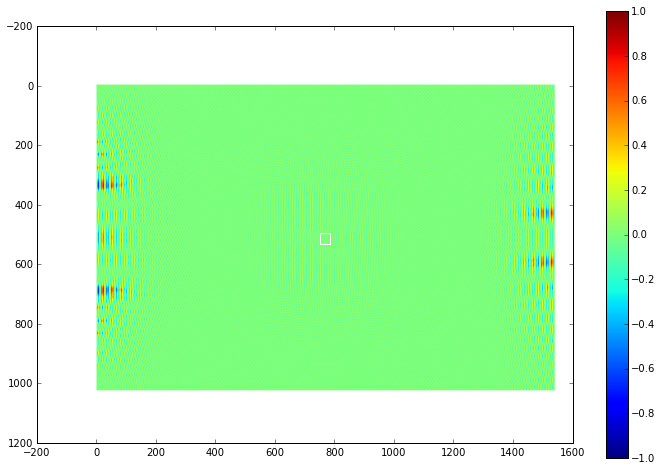

In [29]:
widgets.interact(plot_wave, t=widgets.FloatSliderWidget(min=0, max=tstore[-1], step=tstore[1], value=0));